In [2]:
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

## Read Data

In [4]:
# read data
column_names = ["sentiment", "title", "content"]
df = pd.read_csv('C:/Users/ROG/Desktop/train.csv', header=None, names=column_names)
df['title'].fillna("", inplace=True)
df['sentiment'] = df['sentiment'] - 1

## Data Cleaning

In [5]:
def clean_text(text):
    # HTML
    text = re.sub(r'<.*?>', '', text)
    # lowercase
    text = text.lower()
    # remove punctuation and numbers
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\d+', '', text)
    return text

df['title_cleaned'] = df['title'].apply(clean_text)
df['content_cleaned'] = df['content'].apply(clean_text)
df[['title', 'title_cleaned', 'content', 'content_cleaned']].head()
# stop words
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in stop_words])

df['title_cleaned'] = df['title_cleaned'].apply(remove_stopwords)
df['content_cleaned'] = df['content_cleaned'].apply(remove_stopwords)
df[['title', 'title_cleaned', 'content', 'content_cleaned']].head()
# Stem Extraction
stemmer = PorterStemmer()
def stem_text(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

df['title_cleaned'] = df['title_cleaned'].apply(stem_text)
df['content_cleaned'] = df['content_cleaned'].apply(stem_text)

df[['title', 'title_cleaned', 'content', 'content_cleaned']].head()

,title,title_cleaned,content,content_cleaned
0,Stuning even for the non-gamer,stune even nongam,This sound track was beautiful! It paints the ...,sound track beauti paint seneri mind well woul...
1,The best soundtrack ever to anything.,best soundtrack ever anyth,I'm reading a lot of reviews saying that this ...,im read lot review say best game soundtrack fi...
2,Amazing!,amaz,This soundtrack is my favorite music of all ti...,soundtrack favorit music time hand intens sad ...
3,Excellent Soundtrack,excel soundtrack,I truly like this soundtrack and I enjoy video...,truli like soundtrack enjoy video game music p...
4,"Remember, Pull Your Jaw Off The Floor After He...",rememb pull jaw floor hear,"If you've played the game, you know how divine...",youv play game know divin music everi singl so...


In [7]:
nltk.download('stopwords')

def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = text.lower()
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\d+', '', text)
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in text.split() if word not in stop_words])
    stemmer = PorterStemmer()
    text = " ".join([stemmer.stem(word) for word in text.split()])
    
    return text
# read data
column_names = ["sentiment", "title", "content"]
df = pd.read_csv('C:/Users/ROG/Desktop/train.csv', header=None, names=column_names)
df['title'].fillna("", inplace=True)
df['sentiment'] = df['sentiment'] - 1
df['content_cleaned'] = df['content'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ROG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Description and Visualization

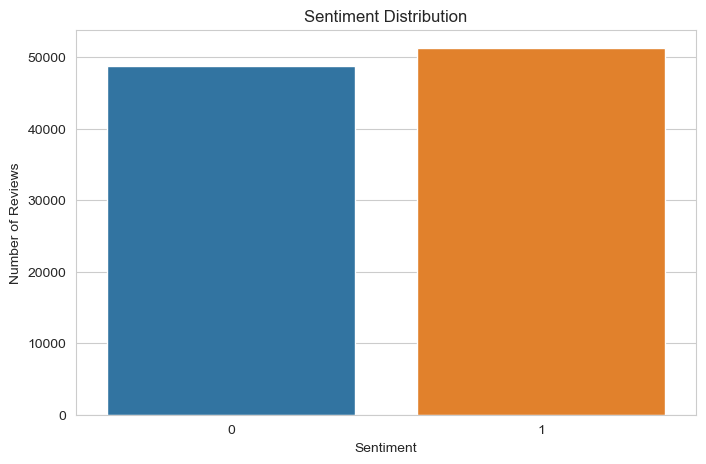

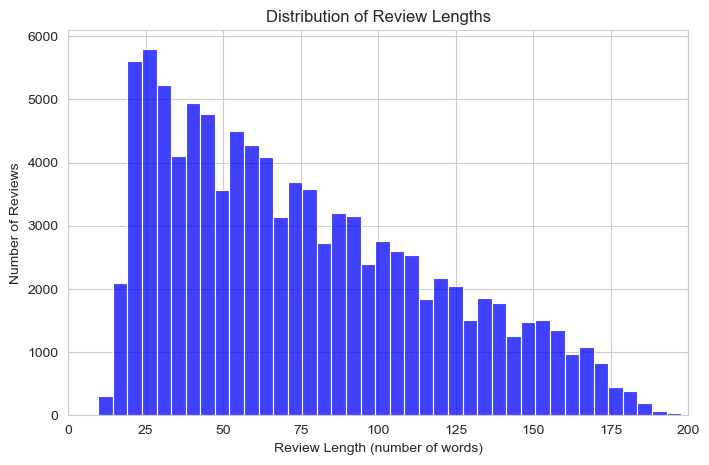

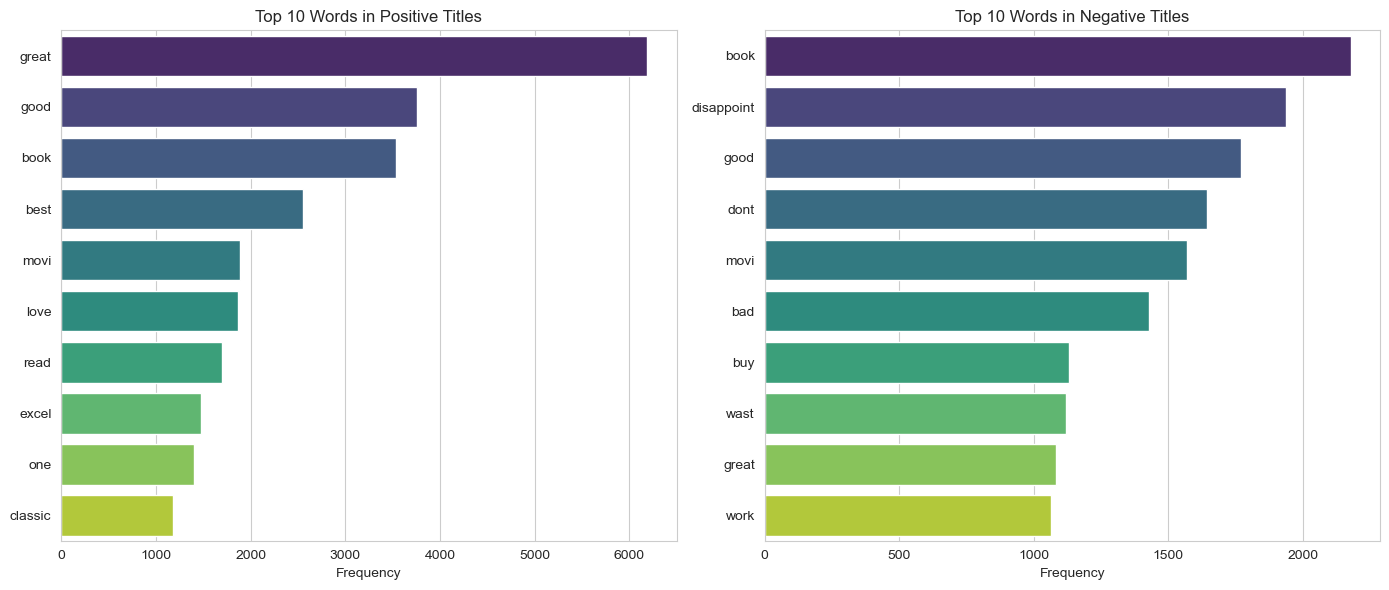

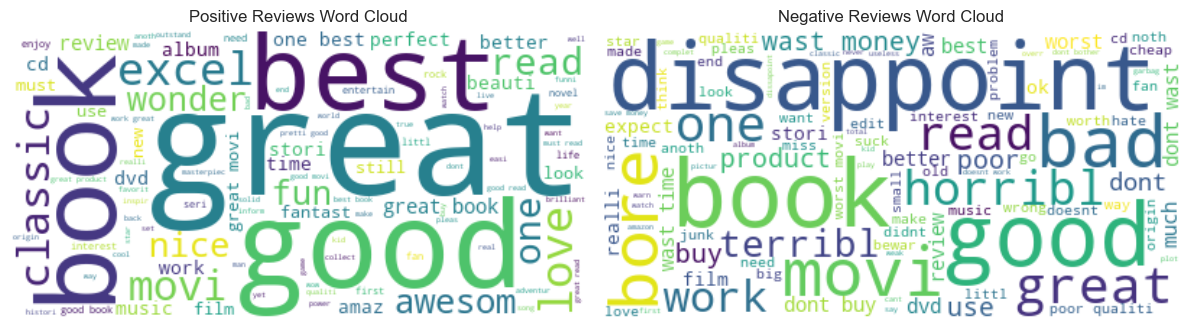

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

# style setting
sns.set_style("whitegrid")

# 1. sentiment distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='sentiment')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

# 2. length distrition
df['content_length'] = df['content'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 5))
sns.histplot(df['content_length'], bins=50, color='blue')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length (number of words)')
plt.ylabel('Number of Reviews')
plt.xlim(0, 200)  # Limiting to 200 for better visibility
plt.show()

# 3. common words
positive_words = ' '.join(df[df['sentiment'] == 1]['title_cleaned'])
negative_words = ' '.join(df[df['sentiment'] == 0]['title_cleaned'])
positive_word_freq = Counter(positive_words.split())
negative_word_freq = Counter(negative_words.split())
# top10
top10_positive_words = positive_word_freq.most_common(10)
top10_negative_words = negative_word_freq.most_common(10)

plt.figure(figsize=(14, 6))
# Positive Titles Word Frequency
plt.subplot(1, 2, 1)
sns.barplot(x=[item[1] for item in top10_positive_words], 
            y=[item[0] for item in top10_positive_words], palette="viridis")
plt.title('Top 10 Words in Positive Titles')
plt.xlabel('Frequency')

# Negative Titles Word Frequency
plt.subplot(1, 2, 2)
sns.barplot(x=[item[1] for item in top10_negative_words], 
            y=[item[0] for item in top10_negative_words], palette="viridis")
plt.title('Top 10 Words in Negative Titles')
plt.xlabel('Frequency')

plt.tight_layout()
plt.show()

# 4. word cloud
plt.figure(figsize=(12, 6))

# Positive Word Cloud
plt.subplot(1, 2, 1)
wordcloud = WordCloud(background_color="white", max_words=100).generate(positive_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews Word Cloud')

# Negative Word Cloud
plt.subplot(1, 2, 2)
wordcloud = WordCloud(background_color="white", max_words=100).generate(negative_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews Word Cloud')

plt.tight_layout()
plt.show()


## Model

In [8]:
# logistic
from joblib import dump
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
# train test split
X = df['content_cleaned']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# use TF-IDF performing feature extraction
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
# model fit
clf = LogisticRegression()
clf.fit(X_train_tfidf, y_train)
dump(clf, 'logistic_regression_model.joblib')
dump(tfidf_vectorizer, 'tfidf_vectorizer.joblib')
# prediction
y_pred = clf.predict(X_test_tfidf)
# results
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

accuracy, classification_rep

(0.85065,
 '              precision    recall  f1-score   support\n\n           0       0.85      0.84      0.84      9602\n           1       0.85      0.86      0.86     10398\n\n    accuracy                           0.85     20000\n   macro avg       0.85      0.85      0.85     20000\nweighted avg       0.85      0.85      0.85     20000\n')

In [10]:
# transformer
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset, random_split
# load BERT and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', use_fast=True)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
# data preprocessing
sub_df = df.head(100000)
inputs = tokenizer.batch_encode_plus(list(sub_df['content_cleaned']), truncation=True, padding=True, max_length=256, return_tensors='pt')
input_ids = inputs["input_ids"]
attention_masks = inputs["attention_mask"]
labels = torch.tensor(sub_df['sentiment'].values)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
input_ids = input_ids.to(device)
attention_masks = attention_masks.to(device)
labels = labels.to(device)
# construct PyTorch datatset
dataset = TensorDataset(input_ids, attention_masks, labels)
# split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32)
val_loader = DataLoader(val_dataset, batch_size=32)

In [11]:
# fine tune
from tqdm import tqdm
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

for epoch in range(3):  # 3 rounds
    model.train()
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch}"):
        input_ids, attention_masks, labels = batch
        outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

# evaluation
model.eval()
all_preds, all_labels = [], []
for batch in val_loader:
    input_ids, attention_masks, labels = batch
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_masks)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)
    all_preds.extend(preds)
    all_labels.extend(labels)

accuracy = (torch.tensor(all_preds) == torch.tensor(all_labels)).float().mean()
print(f"Validation Accuracy: {accuracy:.4f}")


Training Epoch 2: 100%|██████████| 2500/2500 [27:47<00:00,  1.50it/s]


Validation Accuracy: 0.8861


In [17]:
from sklearn.metrics import precision_recall_fscore_support
# Convert the list of tensors to a single tensor and then move it to CPU
all_preds_tensor = torch.stack(all_preds).cpu()
all_labels_tensor = torch.stack(all_labels).cpu()

# Now convert to NumPy arrays
all_preds_array = all_preds_tensor.numpy()
all_labels_array = all_labels_tensor.numpy()

# Calculate the confusion matrix using scikit-learn
precision, recall, f1, _ = precision_recall_fscore_support(all_labels_array, all_preds_array, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



Precision: 0.8867
Recall: 0.8861
F1 Score: 0.8861


## Chatgpt's API

In [10]:
import openai

openai.api_key = ''  

def get_chatgpt_response(comment, product_url, model="gpt-4-1106-preview", max_tokens=60):
    prompt = f"A customer has a concern about the product: '{comment}'. Imagine that you are a competitor of that product and sell the benefits of your own product based on the claim. Don't include sorry and thank you's. Answer in a positive sunny way! don't apologize, and present the benefits of the product(For example, it's cost-effective, very good quality and looks great. Respond to reviews based on their claims). End the response with a link to the product website for additional support."
    
    try:
        response = openai.ChatCompletion.create(
            model=model,
            messages=[{"role": "system", "content": prompt}],
            max_tokens=max_tokens
        )
        reply = response['choices'][0]['message']['content'].strip()
        return f"{reply}\nFor more information, please visit our website: {product_url}"
    except openai.error.OpenAIError as e:
        print(f"An error occurred: {e}")
        return "" 

product_url_example = "http://www.example.com"
n_df = df[df['sentiment'] == 0]
sub_df = n_df.iloc[0:1000]
responses = []
for comment in sub_df['content']: 
    response = get_chatgpt_response(comment, product_url_example)
    responses.append(response)
    

['Embrace a world of quality literature with our latest book release! We understand the importance of crafting a captivating narrative, which is why our book has undergone a rigorous editing process to ensure that every sentence is polished to perfection. Our authors are well-acquainted with the classics, drawing inspiration from the great\nFor more information, please visit our website: http://www.example.com', "We're delighted to hear from discerning readers like you! If you're seeking a literary journey filled with rich storytelling, flawless grammar, and an engaging plot that keeps you turning the pages, we've got just the ticket. Our authors are passionate about creating captivating and error-free narratives that both entertain and\nFor more information, please visit our website: http://www.example.com", "If you're on the hunt for a literary escape that transcends the clichés often found in the romance genre, our latest novel could be the refreshing change you're looking for! Craf

In [13]:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Table(
    header=dict(values=['Comment', 'Response'],
                line_color='darkslategray',
                fill_color='lightskyblue',
                align='center'),
    cells=dict(values=[sub_df['content'], responses],
               line_color='darkslategray',
               fill_color='lightcyan',
               align='left',
               font_size=12,
               height=30))
])


fig.update_layout(width=700, height=400, title_text="Interactive Comments and Responses Table")
fig.show()

## Evaluation of the Quality of Responses

In [56]:
from joblib import load

# Load the saved logistic regression model and TF-IDF vectorizer
clf = load('logistic_regression_model.joblib')
tfidf_vectorizer = load('tfidf_vectorizer.joblib')

# Function to calculate sentiment score
def get_sentiment_score(text):
    text_tfidf = tfidf_vectorizer.transform([text])
    return clf.predict(text_tfidf)[0]


# Calculate sentiment scores
sentiment_scores = []


for response in responses:
    sentiment_scores.append(get_sentiment_score(response))


# Calculate the averages
average_sentiment_score = sum(sentiment_scores) / len(sentiment_scores) if sentiment_scores else 0


# Print or store the average scores
print("Average Sentiment Score:", average_sentiment_score)





Average Sentiment Score: 0.55
